# Intent Classification - Chatbot - FastText Embeddings

In [1]:
from nltk import word_tokenize
import pandas as pd 
import numpy as np
import spacy
import re
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from gensim.models import FastText

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, concatenate, Input


Using TensorFlow backend.


In [3]:
with open("ChatbotCorpus.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
    intent_data = [[dat["text"], dat["intent"]] for dat in data["sentences"]]

In [4]:
df = DataFrame (intent_data,columns=['Chat','Intent'])
df.head()

,Chat,Intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit?,DepartureTime
2,when does the next u-bahn leaves from garching...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstraße 12 to...,FindConnection


In [5]:
def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    return text

In [6]:
df['Chat'] = df['Chat'].apply(clean_text)

In [7]:
df.head()

,Chat,Intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit,DepartureTime
2,when does the next ubahn leaves from garching ...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstrae 12 to ...,FindConnection


In [8]:
intents = df['Intent'].unique()
intents

array(['FindConnection', 'DepartureTime'], dtype=object)

In [9]:
df["words"] = df["Chat"].apply(word_tokenize)

In [10]:
df.head()

,Chat,Intent,words
0,i want to go marienplatz,FindConnection,"[i, want, to, go, marienplatz]"
1,when is the next train in muncher freiheit,DepartureTime,"[when, is, the, next, train, in, muncher, frei..."
2,when does the next ubahn leaves from garching ...,DepartureTime,"[when, does, the, next, ubahn, leaves, from, g..."
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection,"[from, olympia, einkaufszentrum, to, hauptbahn..."
4,when is the next train from winterstrae 12 to ...,FindConnection,"[when, is, the, next, train, from, winterstrae..."


In [11]:
word_list = df.words.tolist()

# Create and save FastText Embeddings

In [14]:
MAX_NB_WORDS = 500
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Chat'].values)
word_index = tokenizer.word_index
NB_WORDS = len(word_index)+1
print('Found %s unique tokens.' % NB_WORDS)

Found 174 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(df['Chat'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (206, 100)


In [16]:
Y = pd.get_dummies(df['Intent']).values

print('Shape of label tensor:', Y.shape)


Shape of label tensor: (206, 2)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = True, test_size = 0.2)

In [18]:
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot( acc, 'b', label='Train')
    plt.plot( val_acc, 'r', label='Test')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot( loss, 'b', label='Train')
    plt.plot(val_loss, 'r', label='Test')
    plt.title('Loss')
    plt.legend()


In [19]:
def pred(model,text,classes):
    text = clean_text(text)
    tokenizer = Tokenizer(num_words=NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts([word_tokenize(text)])
    word_index = tokenizer.word_index
    # Sequence and padding
    P = tokenizer.texts_to_sequences([[text]])
    P = pad_sequences(P, maxlen=MAX_SEQUENCE_LENGTH)
    # print('Shape of tensor:', P.shape)
    # Class Prediction
    predict = model.predict(P)
    #x = np.argmax(predict, axis=-1)
    predict=predict[0]
    for i in range(len(predict)):
        print("%s  = %s" %(classes[i], (predict[i])))

In [20]:
import codecs
f = codecs.open('chat_w2v.txt', encoding='utf-8')

In [21]:
from tqdm import tqdm
embeddings_index = {}
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

print("Done.\n Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
#print(len(embedding_matrix))
print(" Completed!")
f.close()

174it [00:00, 10041.40it/s]

Done.
 Proceeding with Embedding Matrix... Completed!


# LSTM Model with FastText Embeddings

In [30]:
##    LSTM MODEL

model = Sequential()
model.add(Embedding(NB_WORDS, EMBEDDING_DIM, weights = [embedding_matrix], input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(2, activation='softmax'))
#adam = optimizers.Adam(lr=0.00008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          17400     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 102,952
Trainable params: 102,952
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
epochs = 50
batch_size = 32
filename = 'Fasttext_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, Y_test), callbacks = [checkpoint])

Train on 164 samples, validate on 42 samples
Epoch 1/50
164/164 [==============================] - 3s 19ms/sample - loss: 1.9485 - accuracy: 0.5976 - val_loss: 1.8304 - val_accuracy: 0.7143
Epoch 2/50
164/164 [==============================] - 1s 6ms/sample - loss: 1.8388 - accuracy: 0.6220 - val_loss: 1.7413 - val_accuracy: 0.7143
Epoch 3/50
164/164 [==============================] - 1s 6ms/sample - loss: 1.7400 - accuracy: 0.6037 - val_loss: 1.6417 - val_accuracy: 0.7143
Epoch 4/50
164/164 [==============================] - 1s 6ms/sample - loss: 1.6405 - accuracy: 0.6037 - val_loss: 1.5484 - val_accuracy: 0.7143
Epoch 5/50
164/164 [==============================] - 1s 7ms/sample - loss: 1.5474 - accuracy: 0.6280 - val_loss: 1.4610 - val_accuracy: 0.7143
Epoch 6/50
164/164 [==============================] - 1s 7ms/sample - loss: 1.4621 - accuracy: 0.6707 - val_loss: 1.3856 - val_accuracy: 0.9762
Epoch 7/50
164/164 [==============================] - 1s 7ms/sample - loss: 1.3762 - accur

In [32]:
model = load_model("Fasttext_model.h5")
acc = model.evaluate(X_test,Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

42/42 [==============================] - 0s 7ms/sample - loss: 0.0407 - accuracy: 1.0000
Test set
  Loss: 0.041
  Accuracy: 1.000


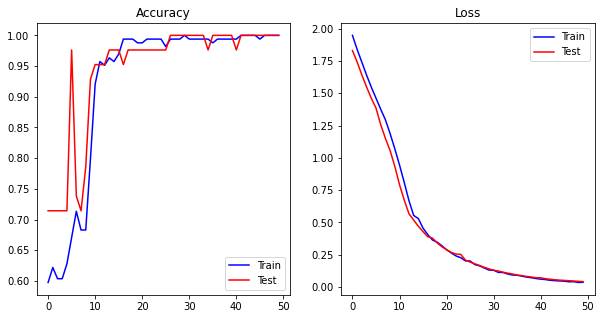

In [33]:
plot(history)

In [41]:
fasttext_model =  load_model("Fasttext_model.h5")

In [42]:
text = "When does the next bus leaves at garching forschungszentrum"
predictions = pred(fasttext_model,text,intents)


FindConnection  = 0.32001847
DepartureTime  = 0.6799815
